In [105]:
# Common modules
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_curve

# Decision tree specific modules
from sklearn import tree

In [15]:
BASE_PATH = os.path.join(os.getcwd(), os.pardir)
DATA_PATH = os.path.join(BASE_PATH, 'data')

In [16]:
train_df = pd.read_json(os.path.join(BASE_PATH, '01-milestone1', 'imputed_train.json'))

In [74]:
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


In [87]:
X = train_df.drop(columns=['interest_level'])
y = train_df['interest_level']

Some features cause difficulty with the Decision Tree model in scikit-learn. Let's temporarily remove these.

In [88]:
X = X.drop(columns=['building_id', 'manager_id', 'description', 'created', 'display_address', 'features', 
                    'street_address', 'listing_id', 'photos'])

## Training the model

We first instantiate a decision tree model and train it naively using all the features.

In [89]:
X.head()

,bathrooms,bedrooms,latitude,longitude,price
10,1.5,3,40.7145,-73.9425,3000
10000,1.0,2,40.7947,-73.9667,5465
100004,1.0,1,40.7388,-74.0018,2850
100007,1.0,1,40.7539,-73.9677,3275
100013,1.0,4,40.8241,-73.9493,3350


In [90]:
# Convert labels from {low, medium high} -> {0, 1, 2}
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

## Train-test split

We need to split the training data into a training set and a validation set (to evaluate the performance of the model).

For now we do an 80-20 split.

In [91]:
seed = 36201431
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [92]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [98]:
y_pred = model.predict(X_test)

## Raw accuracy

In [101]:
acc = accuracy_score(y_test, y_pred)

In [102]:
acc

0.6683228554045832

## Area Under the Curve

In [106]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)

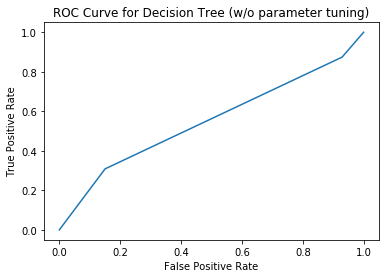

In [110]:
plt.plot(fpr, tpr)
plt.title("ROC Curve for Decision Tree (w/o parameter tuning)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [109]:
auc_score = auc(fpr, tpr)
auc_score

0.5502052063521162